In [2]:
# %%
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from datagen import get_dataloader, create_file_pairs
from plotting import plot_log_residual_contour, plot_histogram
from models import Autoencoder1D, ConvAutoencoder1D

from tqdm import tqdm

os.environ["OPENBLAS_NUM_THREADS"] = "1"
plt.rcParams["figure.dpi"] = 110


In [3]:
# %%
def compute_log_residuals(x_true, x_recon):
    """
    x_true, x_recon: 1D arrays (NumPy)
    Returns: log_x_true, signed log_residual, residual (all NumPy)
    """
    residual = x_true - x_recon
    log_x_true = np.log10(np.abs(x_true) + 1e-12)
    log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)
    return log_x_true, log_residual, residual


def compute_rule_based_residual_magnitude(log_x_true, m=23, epsilon=0.3):
    """
    Rule-based upper/lower lines in log space.
    """
    delta_x = np.log10(2)
    C = -m * delta_x + epsilon
    x_step = np.floor(log_x_true / delta_x) * delta_x
    y_upper = x_step + C
    y_lower = -x_step - C
    y_mid = (y_upper + y_lower) / 2
    return y_mid, y_upper, y_lower, x_step


def plot_rule_based_bounds(log_x_true, log_residual, y_upper, y_lower, x_step, m, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x_true, log_residual, s=5, alpha=0.2, label="Residuals")
    sort_idx = np.argsort(x_step)
    plt.plot(x_step[sort_idx], y_upper[sort_idx], 'r--', label=f"$y = x - {m}\\log_{{10}}2 + \\epsilon$")
    plt.plot(x_step[sort_idx], y_lower[sort_idx], 'b--', label=f"$y = -x + {m}\\log_{{10}}2 - \\epsilon$")
    plt.xlabel("log10(|x_true|)")
    plt.ylabel("Signed log10 residual")
    plt.title("Rule-Based Residual Bounds")
    plt.legend()
    plt.grid(True)
    if save_path is not None:
        out = Path(save_path) / "rule_based_bounds.png"
        plt.savefig(out, bbox_inches="tight")
        plt.close()
        print(f"Rule-based bounds plot saved to {out}")
    else:
        plt.show()


gaussian testing

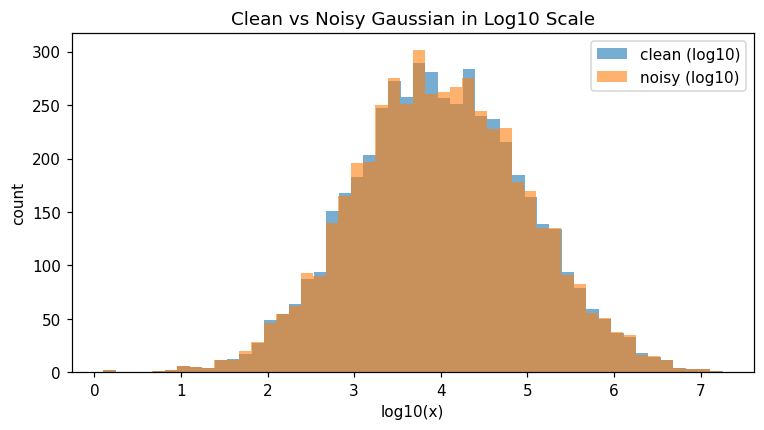

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes

def reduce_float_precision(value, nmantissa):
    # Constants
    NMANTISSA = 23
    MAX_EXPONENT = 0x7f7  # corresponds to max exponent before Inf (254 in biased form)
    MIN_MANTISSA_BITS = 5

    # Convert float32 to raw bits
    float_val = ctypes.c_float(value)
    bits = ctypes.cast(ctypes.pointer(float_val), ctypes.POINTER(ctypes.c_uint32)).contents.value

    # Handle NaN and Inf (do not compress)
    if (bits & 0x7f800000) == 0x7f800000:
        return value  # Already Inf/NaN

    # If full mantissa requested, or invalid range, return original
    if nmantissa >= NMANTISSA or nmantissa <= 0:
        return value

    # Clamp to minimum mantissa
    if nmantissa < MIN_MANTISSA_BITS:
        nmantissa = MIN_MANTISSA_BITS

    # Compute shift and masks
    shift = NMANTISSA - nmantissa
    mask = (~0) << shift  # Keeps upper nmantissa bits
    round_bit = 1 << (shift - 1)

    mantissa = bits & 0x007fffff
    exponent = (bits >> 23) & 0xff

    # Create a mask for vmax check (from C++)
    vmax = (MAX_EXPONENT << 23) | (0x007fffff ^ round_bit)

    # Perform rounding if it won't cause overflow
    if (bits & 0x7fffffff) < vmax:
        mantissa += round_bit

    # Apply mantissa mask (truncate lower bits)
    mantissa &= mask

    # Reassemble final bits
    compressed_bits = (bits & 0xff800000) | mantissa  # keep sign and exponent

    # Convert bits back to float32
    compressed_uint = ctypes.c_uint32(compressed_bits)
    compressed_float = ctypes.cast(ctypes.pointer(compressed_uint), ctypes.POINTER(ctypes.c_float)).contents.value

    return compressed_float

def generate_log_gaussian(n_points=5000, mu=4, sigma=1, nmantissa=5, seed=0):
    """
    Generate samples where log10(x) ~ N(mu, sigma^2).
    
    Args:
        n_points: number of samples
        mu: mean in log10 scale
        sigma: std in log10 scale
        noise_std: Gaussian noise added in *log10 space*
        seed: RNG seed
    
    Returns:
        clean: clean Gaussian in log10 scale (mapped back to linear)
        noisy: noisy samples (perturbed in log10 scale)
    """
    rng = np.random.default_rng(seed)
    log_clean = rng.normal(mu, sigma, size=n_points)   # clean in log space
    clean = 10**log_clean                              # back to linear scale
    
    # Add noise in log scale
    noisy = [reduce_float_precision(i, nmantissa=nmantissa) for i in clean]
    # log_noisy = log_clean + rng.normal(0, noise_std, size=n_points)
    # noisy = 10**log_noisy
    
    return clean, noisy

nmantissa = 5
# Example usage
clean, noisy = generate_log_gaussian(nmantissa=nmantissa)

plt.figure(figsize=(8,4))
plt.hist(np.log10(clean), bins=50, alpha=0.6, label="clean (log10)")
plt.hist(np.log10(noisy), bins=50, alpha=0.6, label="noisy (log10)")
plt.xlabel("log10(x)")
plt.ylabel("count")
plt.legend()
plt.title("Clean vs Noisy Gaussian in Log10 Scale")
plt.show()


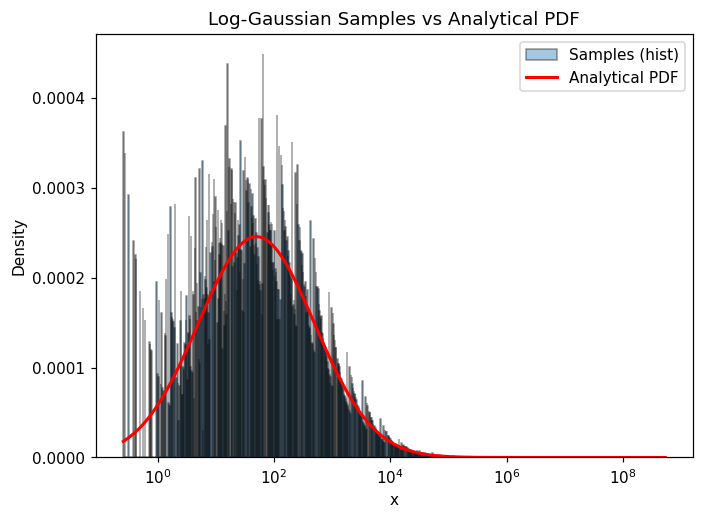

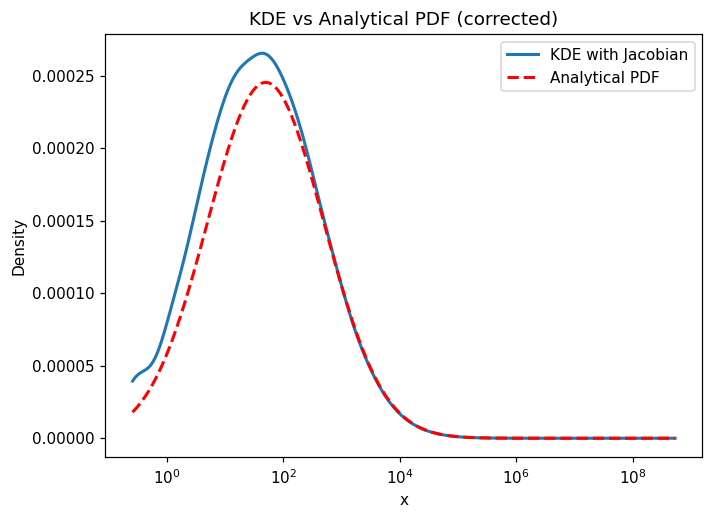

In [114]:
y_mid, y_lower, y_upper, x_step = compute_rule_based_residual_magnitude(np.log10(noisy),m=nmantissa,epsilon=0.5)

# model_predicted = log_gaussian_pdf(noisy, mu=4, sigma=1)

# # plt.scatter(noisy, model_predictetd)
# plt.figure(figsize=(8,4))
# plt.hist(model_predicted, bins=50, alpha=0.6, label="clean (log10)")
# plt.hist(noisy, bins=50, alpha=0.6, label="noisy (log10)")
# plt.xscale("log")
# plt.xlabel("x (linear)")
# plt.ylabel("PDF")
# plt.title("Log-Gaussian PDF in linear space")
# plt.legend()
# plt.show()


def log_gaussian_pdf(x, mu=4, sigma=1):
    x = np.asarray(x)
    if np.any(x <= 0):
        raise ValueError("x must be positive for log10 distribution")
    y = np.log10(x)
    coeff = 1.0 / (sigma * np.sqrt(2*np.pi) * x * np.log(10))
    pdf = coeff * np.exp(-0.5 * ((y - mu) / sigma)**2)
    return pdf

# --- plotting ---
clean, noisy = generate_log_gaussian(n_points=500_000, mu=4, sigma=1)

# log-spaced bins
bins = np.logspace(np.log10(min(clean)), np.log10(max(clean)), 1000)

# histogram (log-binned, normalized to density)
hist, edges = np.histogram(noisy, bins=bins, density=True)
centers = np.sqrt(edges[1:] * edges[:-1])   # geometric mean for log bins

plt.figure(figsize=(7,5))

plt.hist(noisy, bins=bins, density=True, alpha=0.4, edgecolor="k", label="Samples (hist)")

plt.plot(centers, log_gaussian_pdf(centers, mu=4, sigma=1), "r-", lw=2, label="Analytical PDF")

plt.xscale("log")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Log-Gaussian Samples vs Analytical PDF")
plt.legend()
plt.show()

from scipy.stats import gaussian_kde

# log10 transform
log_noisy = np.log10(noisy)
kde = gaussian_kde(log_noisy, bw_method=0.2)  # adjust bandwidth

# evaluation points
x_lin = np.logspace(np.log10(min(noisy)), np.log10(max(noisy)), 500)
x_log = np.log10(x_lin)

# adjust back to linear-space density
pdf_kde = kde(x_log) / (x_lin * np.log(10))  

plt.figure(figsize=(7,5))
plt.plot(x_lin, pdf_kde, lw=2, label="KDE with Jacobian")
plt.plot(centers, log_gaussian_pdf(centers, mu=4, sigma=1), "r--", lw=2, label="Analytical PDF")
plt.xscale("log")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("KDE vs Analytical PDF (corrected)")
plt.legend()
plt.show()




original mse: 54657193.912202455
mse: 46595519.039261706
MSE noisy: 0.00055
MSE corrected: 0.00053
Percentage improvement: 3.67%
-1.5051499783199058 1.5051499783199058


/tmp/ipykernel_553937/358994689.py:324: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(noisy), np.log10(clean-noisy), s=10, alpha=0.3, label="residuals")


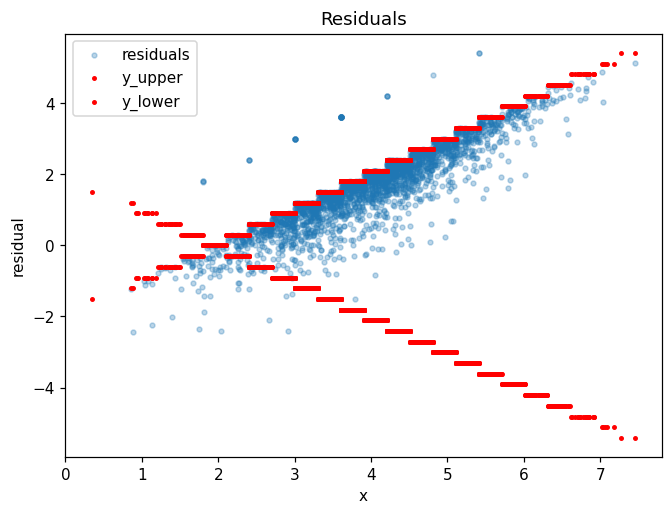

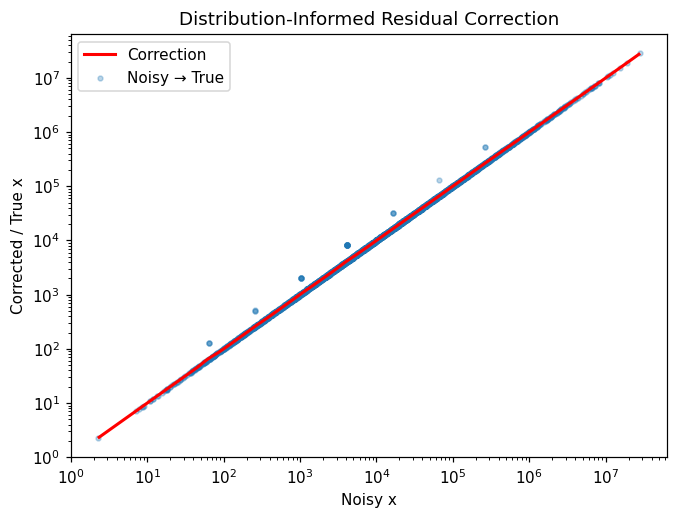

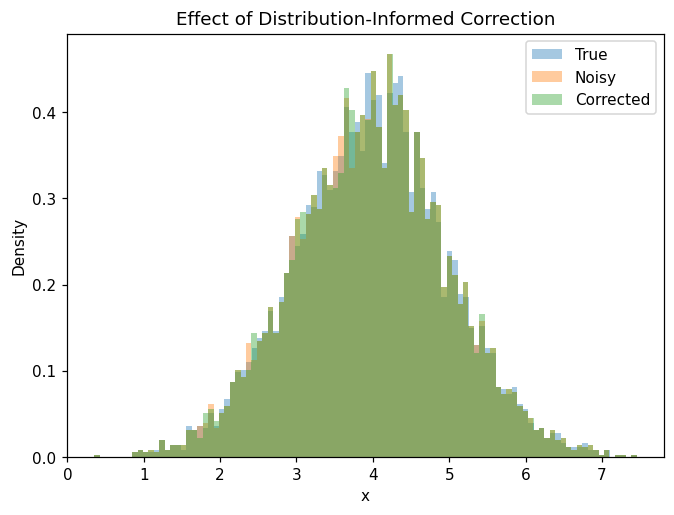

=== Residual-correction with bounds (log10 space) ===
Total points: 5000
Selected for correction: 74  (1.48%)
  - near upper bound: 40
  - near lower bound: 34
--- Overall (all points) ---
MSE noisy:     0.000546037
MSE simple:    0.000553045
MSE corrected: 0.000546979   (vs noisy -0.17%, vs simple 1.10%)
MAE noisy:     0.00425369
MAE simple:    0.0053857
MAE corrected: 0.00430635   (vs noisy -1.24%, vs simple 20.04%)
--- Selected subset only ---
MSE noisy:     7.20671e-06
MSE corrected: 7.08467e-05   (vs noisy -883.06%)
MAE noisy:     0.00223264
MAE corrected: 0.00579079   (vs noisy -159.37%)


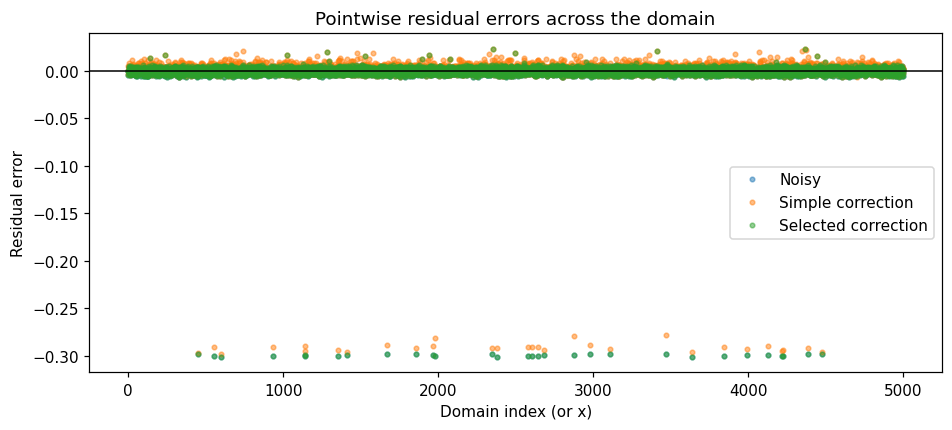

In [163]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from plotting import plot_log_residual_contour

import numpy as np
from scipy.ndimage import gaussian_filter1d

def residual_correction_with_bounds(
    x_noisy,
    x_true,
    compute_rule_based_residual_magnitude,
    m=6,
    epsilon=0.0,
    n_bins=200,
    sigma_smooth=2,
    tol=0.05,         # "closeness" to the bound (in log10-residual units)
    verbose=True
):
    """
    Learn a residual correction from (x_noisy, x_true) in log10 space,
    then apply it ONLY to points whose *true residual* is close to a bound
    from compute_rule_based_residual_magnitude(log10(x_noisy), m, epsilon).

    Args
    ----
    x_noisy, x_true : 1D arrays of positive values (same length)
    compute_rule_based_residual_magnitude : callable
        Should accept (log_x, m, epsilon) -> (y_mid, y_upper, y_lower, x_step)
        where y_* are *log10-scaled residual bounds* (same length as x).
    m, epsilon : parameters passed to the rule-based bound function
    n_bins : # bins for learning the residual correction w.r.t. log10(x_noisy)
    sigma_smooth : Gaussian smoothing (in bins) for the learned residual curve
    tol : tolerance for “close to the bound” (log10 residual units)
          - upper selection: residual <= y_upper and (y_upper - residual) <= tol
          - lower selection: residual >= y_lower and (residual - y_lower) <= tol
    verbose : print debug info

    Returns
    -------
    x_corrected_selected : corrected values (only selected points changed)
    info : dict with debug arrays and metrics
    """

    x_noisy = np.asarray(x_noisy).astype(float)
    x_true  = np.asarray(x_true).astype(float)
    assert x_noisy.shape == x_true.shape, "x_noisy and x_true must match in shape"
    if np.any(x_noisy <= 0) or np.any(x_true <= 0):
        raise ValueError("All values must be > 0 for log10 transform")

    N = x_noisy.size
    log_noisy = np.log10(x_noisy)
    log_true  = np.log10(x_true)

    # --- 1) Learn residual correction in log10 space via binning + smoothing
    residual_true = log_true - log_noisy  # ground-truth residual in log10 units

    # Bin on log_noisy
    bins = np.linspace(log_noisy.min(), log_noisy.max(), n_bins + 1)
    bin_indices = np.digitize(log_noisy, bins) - 1
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_idx = np.digitize(log_noisy, bins) - 1
    bin_idx = np.clip(bin_idx, 0, n_bins - 1)  # keep valid

    # Mean residual per bin (0 if empty)
    delta_bin = np.zeros(n_bins, dtype=float)
    counts = np.zeros(n_bins, dtype=int)
    for i in range(n_bins):
        mask = (bin_idx == i)
        counts[i] = mask.sum()
        if counts[i] > 0:
            delta_bin[i] = residual_true[mask].mean()

    # Smooth the learned residual curve
    delta_smooth = gaussian_filter1d(delta_bin, sigma=sigma_smooth)

    # Per-sample learned correction (log10 units)
    delta_hat = delta_smooth[bin_idx]

    # Map smoothed residuals back to samples
    delta_per_sample = delta_hat[np.clip(bin_indices, 0, n_bins-1)]
    log_corrected_simple = log_noisy + delta_per_sample
    x_corrected_simple = 10**log_corrected_simple

    # --- 2) Compute rule-based bounds at each sample
    # y_lower, y_upper are *log10 residual* bounds (same length as x)
    y_mid, y_upper, y_lower, x_step = compute_rule_based_residual_magnitude(log_noisy, m=m, epsilon=epsilon)

    # --- 3) Select only points "close to, but not beyond" the bounds
    # Upper side: residual <= y_upper AND within tol *below* it
    near_upper = (residual_true <= y_upper) & ((y_upper - residual_true) <= tol)
    # Lower side: residual >= y_lower AND within tol *above* it
    near_lower = (residual_true >= y_lower) & ((residual_true - y_lower) <= tol)

    selected = near_upper | near_lower

    # --- 4) Apply correction ONLY to selected points
    log_corrected_selected = log_noisy.copy()
    log_corrected_selected[selected] = log_noisy[selected] + delta_hat[selected]
    x_corrected_selected = 10 ** log_corrected_selected

        # --- 5) Debug / metrics
    def mse(a): return float(np.mean(a**2))
    def mae(a): return float(np.mean(np.abs(a)))

    # Residuals BEFORE and AFTER (log10 units)
    res_noisy_all     = log_noisy - log_true
    res_corrected_all = np.log10(x_corrected_selected) - log_true
    res_simple_all    = np.log10(x_corrected_simple) - log_true

    n_sel = np.sum(selected)
    n_up  = np.sum(near_upper)
    n_lo  = np.sum(near_lower)

    # Overall metrics
    mse_noisy_all     = mse(res_noisy_all)
    mse_corr_all      = mse(res_corrected_all)
    mse_simple_all    = mse(res_simple_all)
    mae_noisy_all     = mae(res_noisy_all)
    mae_corr_all      = mae(res_corrected_all)
    mae_simple_all    = mae(res_simple_all)

    # Selected-subset metrics
    if np.any(selected):
        res_noisy_sel   = res_noisy_all[selected]
        res_corr_sel    = res_corrected_all[selected]
        res_simple_sel  = res_simple_all[selected]

        mse_noisy_sel   = mse(res_noisy_sel)
        mse_corr_sel    = mse(res_corr_sel)
        mse_simple_sel  = mse(res_simple_sel)

        mae_noisy_sel   = mae(res_noisy_sel)
        mae_corr_sel    = mae(res_corr_sel)
        mae_simple_sel  = mae(res_simple_sel)

        # Improvements wrt noisy
        imp_mse_sel     = 100.0 * (mse_noisy_sel - mse_corr_sel) / max(mse_noisy_sel, 1e-20)
        imp_mae_sel     = 100.0 * (mae_noisy_sel - mae_corr_sel) / max(mae_noisy_sel, 1e-20)

        # Improvements wrt simple
        imp_vs_simple_mse_sel = 100.0 * (mse_simple_sel - mse_corr_sel) / max(mse_simple_sel, 1e-20)
        imp_vs_simple_mae_sel = 100.0 * (mae_simple_sel - mae_corr_sel) / max(mae_simple_sel, 1e-20)
    else:
        mse_noisy_sel = mse_corr_sel = mae_noisy_sel = mae_corr_sel = np.nan
        mse_simple_sel = mae_simple_sel = np.nan
        imp_mse_sel = imp_mae_sel = np.nan
        imp_vs_simple_mse_sel = imp_vs_simple_mae_sel = np.nan

    # Overall improvements
    imp_mse_all = 100.0 * (mse_noisy_all - mse_corr_all) / max(mse_noisy_all, 1e-20)
    imp_mae_all = 100.0 * (mae_noisy_all - mae_corr_all) / max(mae_noisy_all, 1e-20)

    imp_vs_simple_mse_all = 100.0 * (mse_simple_all - mse_corr_all) / max(mse_simple_all, 1e-20)
    imp_vs_simple_mae_all = 100.0 * (mae_simple_all - mae_corr_all) / max(mae_simple_all, 1e-20)

    if verbose:
        print("=== Residual-correction with bounds (log10 space) ===")
        print(f"Total points: {N}")
        print(f"Selected for correction: {n_sel}  ({n_sel/N:.2%})")
        print(f"  - near upper bound: {n_up}")
        print(f"  - near lower bound: {n_lo}")
        print("--- Overall (all points) ---")
        print(f"MSE noisy:     {mse_noisy_all:.6g}")
        print(f"MSE simple:    {mse_simple_all:.6g}")
        print(f"MSE corrected: {mse_corr_all:.6g}   "
              f"(vs noisy {imp_mse_all:.2f}%, vs simple {imp_vs_simple_mse_all:.2f}%)")
        print(f"MAE noisy:     {mae_noisy_all:.6g}")
        print(f"MAE simple:    {mae_simple_all:.6g}")
        print(f"MAE corrected: {mae_corr_all:.6g}   "
              f"(vs noisy {imp_mae_all:.2f}%, vs simple {imp_vs_simple_mae_all:.2f}%)")
        if np.any(selected):
            print("--- Selected subset only ---")
            print(f"MSE noisy:     {mse_noisy_sel:.6g}")
            print(f"MSE corrected: {mse_corr_sel:.6g}   "
                f"(vs noisy {imp_mse_sel:.2f}%)")
            print(f"MAE noisy:     {mae_noisy_sel:.6g}")
            print(f"MAE corrected: {mae_corr_sel:.6g}   "
                f"(vs noisy {imp_mae_sel:.2f}%)")
        else:
            print("--- Selected subset only ---")
            print("No points selected; consider increasing tol or reviewing bounds.")

    info = {
        "selected_mask": selected,
        "near_upper_mask": near_upper,
        "near_lower_mask": near_lower,
        "delta_hat_log": delta_hat,
        "residual_true_log": residual_true,
        "residual_noisy_log": res_noisy_all,
        "residual_corrected_log": res_corrected_all,
        "bin_centers_log": bin_centers,
        "delta_smooth_bin_log": delta_smooth,
        "counts_per_bin": counts,
        # metrics (overall)
        "mse_noisy_all": mse_noisy_all,
        "mae_noisy_all": mae_noisy_all,
        "mse_simple_all": mse_simple_all,
        "mae_simple_all": mae_simple_all,
        "mse_corr_all": mse_corr_all,
        "mae_corr_all": mae_corr_all,
        "improvement_mse_all_pct": imp_mse_all,
        "improvement_mae_all_pct": imp_mae_all,
        "improvement_vs_simple_mse_all_pct": imp_vs_simple_mse_all,
        "improvement_vs_simple_mae_all_pct": imp_vs_simple_mae_all,
        # metrics (selected subset)
        "mse_noisy_selected": mse_noisy_sel,
        "mae_noisy_selected": mae_noisy_sel,
        "mse_simple_selected": mse_simple_sel,
        "mae_simple_selected": mae_simple_sel,
        "mse_corr_selected": mse_corr_sel,
        "mae_corr_selected": mae_corr_sel,
        "improvement_mse_selected_pct": imp_mse_sel,
        "improvement_mae_selected_pct": imp_mae_sel,
        "improvement_vs_simple_mse_selected_pct": imp_vs_simple_mse_sel,
        "improvement_vs_simple_mae_selected_pct": imp_vs_simple_mae_sel,
        "n_selected": n_sel,
        "n_near_upper": n_up,
        "n_near_lower": n_lo,
    }


    # error after correction
    error_corr = (log_corrected_selected - log_true)
    error_simple = (log_noisy + delta_hat - log_true)
    error_noisy = (log_noisy - log_true)

    x_axis = np.arange(len(log_true))  # or your actual domain variable

    plt.figure(figsize=(10,4))
    plt.plot(x_axis, error_noisy, '.', alpha=0.5, label="Noisy")
    plt.plot(x_axis, error_simple, '.', alpha=0.5, label="Simple correction")
    plt.plot(x_axis, error_corr, '.', alpha=0.5, label="Selected correction")
    plt.axhline(0, color='k', lw=1)
    plt.legend()
    plt.xlabel("Domain index (or x)")
    plt.ylabel("Residual error")
    plt.title("Pointwise residual errors across the domain")
    plt.show()


    return x_corrected_selected, info


def residual_correction(x_noisy, x_true, n_bins=200, sigma_smooth=2):
    """
    Learn a correction term from noisy samples to true samples using the distribution.
    
    Args:
        x_noisy : 1D array of noisy samples
        x_true  : 1D array of true samples (same length)
        n_bins  : number of bins in log-space
        sigma_smooth : smoothing parameter for Gaussian filter
        
    Returns:
        x_corrected : corrected noisy samples
        delta_smooth : smoothed correction per bin (for visualization)
        bin_centers : log-space bin centers
    """
    # Ensure positive values (for log-scale)
    x_noisy = np.asarray(x_noisy)
    x_true = np.asarray(x_true)
    assert len(x_noisy) == len(x_true), "Arrays must have same length"
    
    # Log10 transform
    log_noisy = np.log10(x_noisy)
    log_true = np.log10(x_true)
    
    # Compute residuals in log-space
    residuals = log_true - log_noisy
    
    # Bin noisy data in log-space
    bins = np.linspace(log_noisy.min(), log_noisy.max(), n_bins+1)
    bin_centers = 0.5*(bins[:-1]+bins[1:])
    # digitize and clip
    bin_indices = np.digitize(log_noisy, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins-1)   # <-- ensures valid indices

    
    # Compute mean residual per bin
    delta_bin = np.zeros(n_bins)
    for i in range(n_bins):
        if np.any(bin_indices == i):
            delta_bin[i] = residuals[bin_indices == i].mean()
    
    # Smooth residuals
    delta_smooth = gaussian_filter1d(delta_bin, sigma=sigma_smooth)
    
    # Map smoothed residuals back to samples
    x_corrected_log = log_noisy + delta_smooth[bin_indices]
    x_corrected = 10**x_corrected_log
    
    return x_corrected, delta_smooth, bin_centers

# ------------------------------
# Example usage
# ------------------------------
clean, noisy = generate_log_gaussian(n_points=5000, mu=4, sigma=1, nmantissa=5, seed=42)

x_corrected, delta_smooth, bin_centers = residual_correction(noisy, clean, n_bins=200, sigma_smooth=2)

print(f"original mse: {np.mean((noisy - clean)**2)}")
print(f"mse: {np.mean((x_corrected - clean)**2)}")
# Log-space residuals
log_noisy = np.log10(noisy)
log_corrected = np.log10(x_corrected)
log_clean = np.log10(clean)

res_noisy = log_noisy - log_clean
res_corrected = log_corrected - log_clean

mse_noisy = np.mean(res_noisy**2)
mse_corrected = np.mean(res_corrected**2)

improvement_pct = 100 * (mse_noisy - mse_corrected) / mse_noisy
print(f"MSE noisy: {mse_noisy:.5f}")
print(f"MSE corrected: {mse_corrected:.5f}")
print(f"Percentage improvement: {improvement_pct:.2f}%")

y_mid, y_lower, y_upper, x_step = compute_rule_based_residual_magnitude(np.log10(noisy),m=6,epsilon=0)
print(y_lower.min(), y_upper.max())
# plot_log_residual_contour(np.array(clean), np.array(noisy), gmm=None, varname="pt", m=6, offset=-0.2, save_path=None)
plt.figure(figsize=(7,5))
plt.scatter(np.log10(noisy), np.log10(clean-noisy), s=10, alpha=0.3, label="residuals")
plt.scatter(np.log10(noisy), y_upper, c='r', s=5, label='y_upper')
plt.scatter(np.log10(noisy), y_lower, c='r', s=5, label='y_lower')
plt.xlabel("x")
plt.ylabel("residual")
plt.title("Residuals")
plt.legend()
plt.show()

# Plot correction function
plt.figure(figsize=(7,5))
plt.plot(10**bin_centers, 10**(bin_centers + delta_smooth), "r-", lw=2, label="Correction")
plt.scatter(noisy, clean, s=10, alpha=0.3, label="Noisy → True")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Noisy x")
plt.ylabel("Corrected / True x")
plt.title("Distribution-Informed Residual Correction")
plt.legend()
plt.show()

# Compare histograms
plt.figure(figsize=(7,5))
plt.hist(np.log10(clean), bins=100, alpha=0.4, label="True", density=True)
plt.hist(np.log10(noisy), bins=100, alpha=0.4, label="Noisy", density=True)
plt.hist(np.log10(x_corrected), bins=100, alpha=0.4, label="Corrected", density=True)
# plt.xscale("log")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Effect of Distribution-Informed Correction")
plt.legend()
plt.show()

# Assume you have clean, noisy already and a function:
#   compute_rule_based_residual_magnitude(log_x, m, epsilon)
x_corrected, dbg = residual_correction_with_bounds(
    noisy, clean, compute_rule_based_residual_magnitude,
    m=6, epsilon=0, n_bins=200, sigma_smooth=2, tol=0.05, verbose=True
)


below is actual stuff

In [5]:
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

device = "cuda" if torch.cuda.is_available() else "cpu"
branch = "AnalysisElectronsAuxDyn"
varnames = ["pt"]
batch_size = 1000
dataloader = get_dataloader(branch=branch, varnames=varnames, batch_size=batch_size, shuffle=False)

# [Norm] mean=29603.1, std=34961.9, min=712, max=716800
mean_src = 29603.1
std_src = 34961.9  
noise_std = 0.01

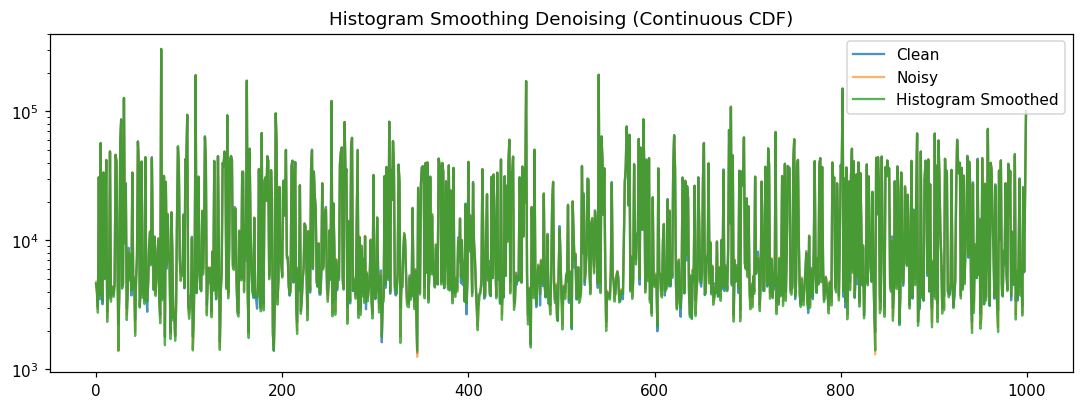

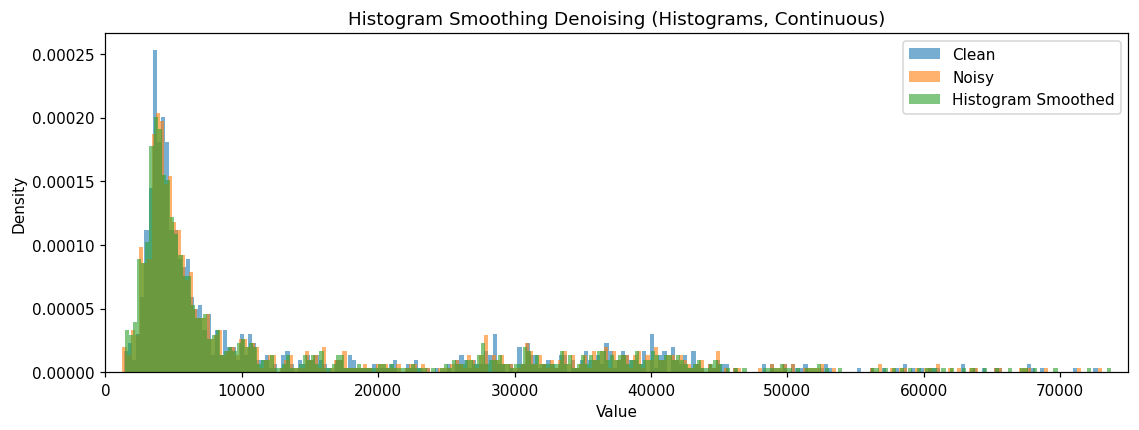

In [ ]:
# grab one sample
x_compressed, residual = next(iter(dataloader))
x_clean = x_compressed.squeeze(1).to(device)
residual = residual.squeeze().to(device)

# normalize + add noise
x_norm = (x_clean - mean_src) / (std_src + 1e-8)
x_noisy = x_norm + torch.randn_like(x_norm) * noise_std
x_noisy_np = x_noisy.cpu().numpy()

# smooth histogram method
bins = 1000
hist, bin_edges = np.histogram(x_noisy_np, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# smooth the PDF
sigma = 0.5
pdf_smooth = gaussian_filter1d(hist, sigma=sigma)
cdf_smooth = np.cumsum(pdf_smooth)
cdf_smooth /= cdf_smooth[-1]

# map original data to smoothed histogram
# first, get empirical CDF of the noisy data
x_sorted = np.sort(x_noisy_np)
empirical_cdf = np.arange(1, len(x_sorted)+1) / len(x_sorted)

# inverse CDF mapping
denoised_sorted = np.interp(empirical_cdf, cdf_smooth, bin_centers)

# map back to original order
denoised = np.empty_like(x_noisy_np)
denoised[np.argsort(x_noisy_np)] = denoised_sorted
denoised = torch.tensor(denoised, device=x_noisy.device)

# de-normalize
x_noisy_denorm = (x_noisy * (std_src + 1e-8)) + mean_src
denoised_denorm = (denoised * (std_src + 1e-8)) + mean_src

# plot
plt.figure(figsize=(12,4))
plt.plot(x_clean.cpu().numpy(), label="Clean", alpha=0.8)
plt.plot(x_noisy_denorm.cpu().numpy(), label="Noisy", alpha=0.6)
plt.plot(denoised_denorm.cpu().numpy(), label="Histogram Smoothed", alpha=0.8)
plt.yscale('log')
plt.legend()
plt.title("Histogram Smoothing Denoising (Continuous CDF)")
plt.show()

# histogram plot
plt.figure(figsize=(12,4))
plt.hist(x_clean.cpu().numpy(), bins=bins, alpha=0.6, label="Clean", density=True)
plt.hist(x_noisy_denorm.cpu().numpy(), bins=bins, alpha=0.6, label="Noisy", density=True)
plt.hist(denoised_denorm.cpu().numpy(), bins=bins, alpha=0.6, label="Histogram Smoothed", density=True)
plt.legend()
plt.title("Histogram Smoothing Denoising (Histograms, Continuous)")
plt.xlim(0,75000)
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()


In [68]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.ndimage import gaussian_filter1d


# def histogram_residual_denoiser(x_noisy, y_lower, y_upper, bins=300, sigma=0.5, threshold=0.2, debug=True):
#     """
#     x_noisy: 1D numpy array
#     y_lower, y_upper: 1D numpy arrays of same length defining expected log-residual bounds
#     threshold: float, margin threshold for conditional correction
#     debug: bool, whether to plot log_residual vs original x_noisy
#     returns: denoised data (1D numpy array)
#     """
#     # Step 1: Histogram smoothing to generate candidate denoised signal
#     hist, bin_edges = np.histogram(x_noisy, bins=bins, density=True)
#     pdf_smooth = gaussian_filter1d(hist, sigma=sigma)
#     cdf_smooth = np.cumsum(pdf_smooth)
#     cdf_smooth /= cdf_smooth[-1]
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#     # Map data to smoothed histogram via CDF
#     x_sorted = np.sort(x_noisy)
#     empirical_cdf = np.arange(1, len(x_sorted)+1) / len(x_sorted)
#     candidate_sorted = np.interp(empirical_cdf, cdf_smooth, bin_centers)
#     denoised_candidate = np.empty_like(x_noisy)
#     denoised_candidate[np.argsort(x_noisy)] = candidate_sorted

#     # Step 2: Compute residuals
#     residual = denoised_candidate - x_noisy
#     log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)

#     # Step 3: Debug scatter plot
#     if debug:
#         plt.figure(figsize=(8,5))
#         plt.scatter(x_noisy, log_residual, s=10, alpha=0.6)
#         plt.scatter(x_noisy, y_upper, c='r', s=5, label='y_upper')
#         plt.scatter(x_noisy, y_lower, c='r', s=5, label='y_lower')
#         plt.xlabel("Original x_noisy")
#         plt.ylabel("log_residual")
#         plt.xscale('log')
#         plt.title("Debug: log_residual vs x_noisy")
#         plt.grid(True)
#         plt.show()

#     # Step 4: Conditional correction based on original logic
#     corrected_residual = np.zeros_like(residual)
#     for j in range(len(log_residual)):
#         res = log_residual[j]
#         if res < 0:
#             neg_res = -res
#             margin = neg_res - y_lower[j]
#             if np.abs(margin) < threshold and (neg_res > y_lower[j]):
#                 corrected_residual[j] = np.sign(neg_res) * 10**np.abs(neg_res)
#         elif res > 0:
#             pos_res = -res
#             margin = y_upper[j] - pos_res
#             if np.abs(margin) < threshold and (pos_res < y_upper[j]):
#                 corrected_residual[j] = np.sign(pos_res) * 10**np.abs(pos_res)

#     print(f"nonzero elements: {np.count_nonzero(corrected_residual)}")
#     # Step 5: Apply corrections
#     denoised_corrected = x_noisy + corrected_residual

#     return denoised_corrected



# # --- Main loop ---
# all_original = []
# all_reconstructed = []
# all_compressed = []
# all_model_pred = []
# all_log_x_true = []
# all_y_upper = []
# all_y_lower = []

# with torch.no_grad():
#     for i, (x_compressed, residual) in enumerate(dataloader):
#         x_compressed = x_compressed.to(device)   # (L,1)
#         residual = residual.to(device)           # (L,1)

#         # Ground truth
#         x_true = x_compressed + residual
#         all_original.append(x_true.cpu())
#         all_compressed.append(x_compressed.cpu())

#         # Normalize input
#         x_clean = (x_compressed - mean_src) / (std_src + 1e-8)
#         x_input = x_clean.squeeze().cpu().numpy()  # 1D numpy array

#         # --- Compute residual bounds for log-scale residual ---
#         log_x_true = np.log10(np.abs(x_true.squeeze().cpu().numpy()) + 1e-12)
#         y_mid, y_upper, y_lower, x_step = compute_rule_based_residual_magnitude(
#             log_x_true, m=10, epsilon=0.5
#         )
#         all_log_x_true.append(log_x_true)
#         all_y_upper.append(y_upper)
#         all_y_lower.append(y_lower)

#         # --- Histogram + Residual-Aware Denoising ---
#         denoised_corrected = histogram_residual_denoiser(x_input, y_lower, y_upper, sigma=2)
#         all_model_pred.append(torch.tensor(denoised_corrected))

#         # --- Reconstructed data ---
#         all_reconstructed.append(torch.tensor(denoised_corrected))

#         if i > 4:
#             break

# # --- Stack results ---
# all_original = torch.cat(all_original).numpy().flatten()
# all_compressed = torch.cat(all_compressed).numpy().flatten()
# all_reconstructed = torch.cat(all_reconstructed).numpy().flatten()
# all_model_pred = torch.cat(all_model_pred).numpy().flatten()
# all_log_x_true = np.concatenate(all_log_x_true)
# all_y_upper = np.concatenate(all_y_upper)
# all_y_lower = np.concatenate(all_y_lower)

# # --- Compute residuals ---
# residual_corrected = all_reconstructed - all_original
# residual_model = all_compressed - all_original

# log_residual_corrected = np.sign(residual_corrected) * np.log10(np.abs(residual_corrected) + 1e-12)
# log_residual_model = np.sign(residual_model) * np.log10(np.abs(residual_model) + 1e-12)

# # --- Plots ---
# plt.figure(figsize=(12,4))
# plt.hist(all_model_pred, bins=1000, alpha=0.6, label="Prediction", density=True)
# plt.legend()
# plt.title("Histogram + Residual-Aware Denoiser (Prediction Histogram)")
# plt.xlabel("Value")
# plt.ylabel("Density")
# plt.xlim(0, 75000)
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.scatter(all_compressed, log_residual_corrected, s=10, alpha=0.6, c='blue', label='Corrected Residuals')
# plt.scatter(all_compressed, log_residual_model, s=10, alpha=0.6, c='orange', label='Compressed Residuals')
# plt.scatter(10**all_log_x_true, all_y_upper, c='r', s=5, label='y_upper')
# plt.scatter(10**all_log_x_true, all_y_lower, c='r', s=5, label='y_lower')
# plt.xlabel("Compressed Value")
# plt.ylabel("Signed log10 Residual (Reconstructed - Original)")
# plt.title("Scatter: Corrected vs Compressed Residuals")
# plt.grid(True)
# plt.xscale('log')
# plt.legend()
# plt.show()

# print("MSE compressed → original:", np.average((all_original - all_compressed)**2))
# print("MSE corrected  → original:", np.average((all_original - all_reconstructed)**2))


In [73]:

def histogram_residual_denoiser_debug(x_noisy, y_lower, y_upper, bins=1000, sigma=0.5, threshold=0.4):
    """
    Returns denoised data and residuals for visualization,
    and prints debug statistics about the corrections.
    """
    # Step 1: Histogram smoothing
    hist, bin_edges = np.histogram(x_noisy, bins=bins, density=True)
    pdf_smooth = gaussian_filter1d(hist, sigma=sigma)
    cdf_smooth = np.cumsum(pdf_smooth)
    cdf_smooth /= cdf_smooth[-1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    print("_______", y_lower[:5])
    print("_______", y_upper[:5])
    x_sorted = np.sort(x_noisy)
    empirical_cdf = np.arange(1, len(x_sorted)+1) / len(x_sorted)
    candidate_sorted = np.interp(empirical_cdf, cdf_smooth, bin_centers)
    denoised_candidate = np.empty_like(x_noisy)
    denoised_candidate[np.argsort(x_noisy)] = candidate_sorted

    # Step 2: Compute residuals before correction
    residual_before = denoised_candidate - x_noisy
    log_residual_before = np.sign(residual_before) * np.log10(np.abs(residual_before) + 1e-12)

    # Step 3: Apply conditional correction
    corrected_residual = np.zeros_like(residual_before)
    corrected_flags = np.zeros_like(residual_before, dtype=bool)

    for j in range(len(log_residual_before)):
        res = log_residual_before[j]
        if res > 0:
            neg_res = -res
            margin = neg_res - y_lower[j]
            if np.abs(margin) < threshold and (neg_res > y_lower[j]):
                corrected_residual[j] = 10**np.abs(neg_res)
                corrected_flags[j] = True
        elif res < 0:
            pos_res = -res
            margin = y_upper[j] - pos_res
            if np.abs(margin) < threshold and (pos_res < y_upper[j]):
                corrected_residual[j] = -1 * 10**np.abs(pos_res)
                corrected_flags[j] = True

    # Step 4: Apply correction
    denoised_corrected = x_noisy + corrected_residual
    residual_after = denoised_corrected - x_noisy
    log_residual_after = np.sign(residual_after) * np.log10(np.abs(residual_after) + 1e-12)

    # --- Debug statistics ---
    total_points = len(x_noisy)
    n_nonzero_before = np.count_nonzero(residual_before)
    n_nonzero_after = np.count_nonzero(residual_after)
    n_corrected = np.count_nonzero(corrected_flags)
    max_res_before = np.max(np.abs(residual_before))
    max_res_after = np.max(np.abs(residual_after))

    print(f"Total points: {total_points}")
    print(f"Non-zero residuals before correction: {n_nonzero_before}")
    print(f"Non-zero residuals after correction: {n_nonzero_after}")
    print(f"Number of points actually corrected: {n_corrected}")
    print(f"Max residual before correction: {max_res_before:.5g}")
    print(f"Max residual after correction: {max_res_after:.5g}")
    print(f"Fraction corrected: {n_corrected/total_points:.4f}")

    return denoised_corrected, log_residual_before, log_residual_after, corrected_flags

_______ [1.10205999 1.10205999 0.80103    1.70411998 0.80103   ]
_______ [-1.10205999 -1.10205999 -0.80103    -1.70411998 -0.80103   ]
Total points: 1000
Non-zero residuals before correction: 1000
Non-zero residuals after correction: 0
Number of points actually corrected: 0
Max residual before correction: 1.1168e+05
Max residual after correction: 0
Fraction corrected: 0.0000


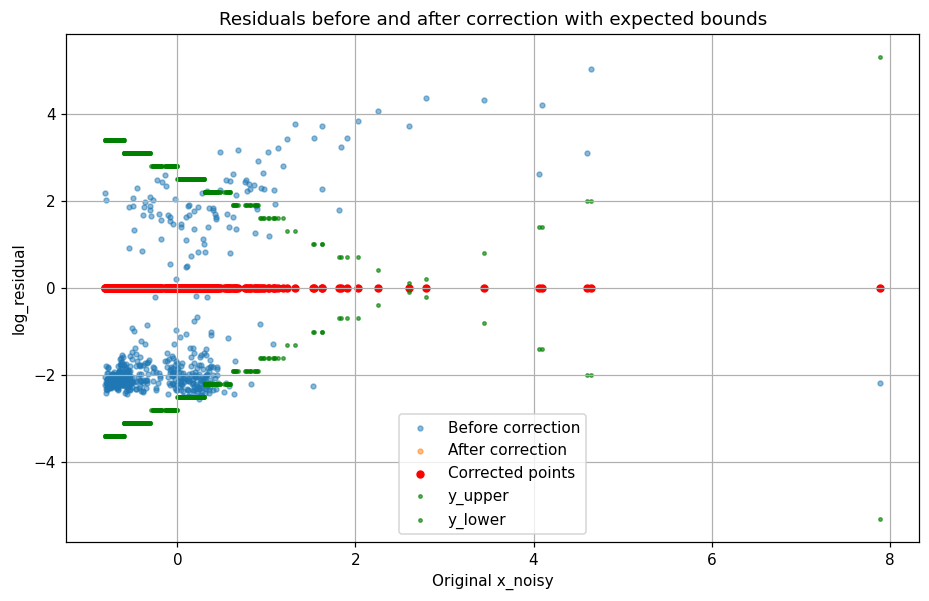

In [81]:
x_input, residual= next(iter(dataloader))
log_x_input = np.log10(np.abs(x_input.squeeze().cpu().numpy()) + 1e-12)
y_mid, y_lower, y_upper, x_step = compute_rule_based_residual_magnitude(log_x_input,m=10,epsilon=0.5)
denoised, log_res_before, log_res_after,corrected_flags = histogram_residual_denoiser_debug(x_input.squeeze().cpu().numpy(), y_lower, y_upper, threshold=0.2)

# Identify which points were actually changed
corrected_mask = log_res_before != log_res_after

plt.figure(figsize=(10,6))

# Scatter before correction
plt.scatter(x_noisy_np, log_res_before, s=10, alpha=0.5, label="Before correction")

# Scatter after correction
plt.scatter(x_noisy_np, log_res_after, s=10, alpha=0.5, label="After correction")

# Highlight corrected points
plt.scatter(x_noisy_np[corrected_mask], log_res_after[corrected_mask], s=20, c='red', label="Corrected points")

# Overlay expected residual bounds
y_mid, y_lower, y_upper, x_step = compute_rule_based_residual_magnitude(x_noisy_np,m=10,epsilon=0.5)
plt.scatter(x_noisy_np, y_upper, s=5, c='green', alpha=0.6, label="y_upper")
plt.scatter(x_noisy_np, y_lower, s=5, c='green', alpha=0.6, label="y_lower")

plt.xlabel("Original x_noisy")
plt.ylabel("log_residual")
plt.title("Residuals before and after correction with expected bounds")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
margin, neg_res, y_lower

(np.float64(-0.17473626740763315),
 np.float32(-1.942357),
 array([ 3.41338994,  3.41338994,  3.41338994,  2.51029996,  3.41338994,
         1.90823997,  3.41338994,  3.41338994,  2.51029996,  3.41338994,
         3.11235995,  2.20926996,  3.41338994,  3.41338994,  3.41338994,
         2.20926996,  3.41338994,  3.41338994,  3.41338994,  3.41338994,
         3.41338994,  2.20926996,  2.20926996,  3.41338994,  3.41338994,
         3.41338994,  1.90823997,  1.00514998,  3.41338994,  3.41338994,
        -0.19897   ,  3.11235995,  2.81132995,  3.41338994,  3.41338994,
         3.41338994,  3.41338994,  3.41338994,  3.41338994,  2.51029996,
         3.41338994,  3.41338994,  3.41338994,  3.41338994,  3.41338994,
         1.90823997,  2.51029996,  3.41338994,  3.41338994,  2.20926996,
         3.41338994,  3.41338994,  3.41338994,  2.20926996,  3.41338994,
         3.41338994,  3.41338994,  3.11235995,  3.11235995,  3.41338994,
         2.20926996,  3.11235995,  3.41338994,  3.11235995,  3.41

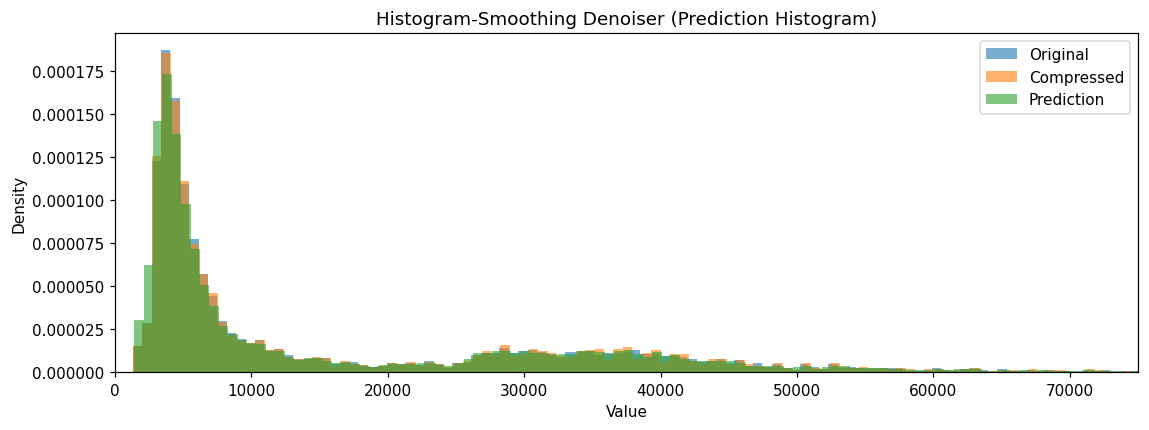

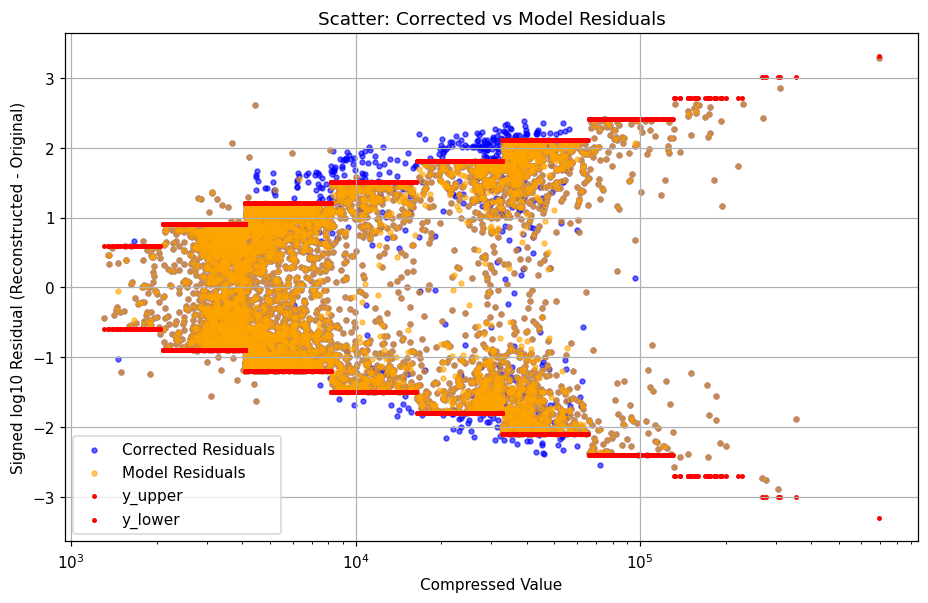

MSE compressed → original: 3023.6174
MSE corrected  → original: 3433.9893


In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# --- Define histogram smoothing denoiser ---
def model_like_denoiser(x_input, sigma=1):
    """
    x_input: (1, 1, L) normalized tensor
    returns: (1, 1, L) tensor in same normalized space
    """
    x_noisy_np = x_input.squeeze().cpu().numpy()  # (L,)
    
    # Compute histogram
    bins = 1000
    hist, bin_edges = np.histogram(x_noisy_np, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Smooth PDF
    pdf_smooth = gaussian_filter1d(hist, sigma=sigma)
    cdf_smooth = np.cumsum(pdf_smooth)
    cdf_smooth /= cdf_smooth[-1]

    # Map original data via continuous CDF
    x_sorted = np.sort(x_noisy_np)
    empirical_cdf = np.arange(1, len(x_sorted)+1) / len(x_sorted)
    denoised_sorted = np.interp(empirical_cdf, cdf_smooth, bin_centers)

    # Map back to original order
    denoised_np = np.empty_like(x_noisy_np)
    denoised_np[np.argsort(x_noisy_np)] = denoised_sorted

    return torch.tensor(denoised_np, device=x_input.device).unsqueeze(0).unsqueeze(0)  # (1,1,L)

# --- Main loop with "model" replaced ---
all_original = []
all_reconstructed = []
all_compressed = []
all_model_pred = []
all_log_x_true = []
all_y_upper = []
all_y_lower = []

with torch.no_grad():
    for i, (x_compressed, residual) in enumerate(dataloader):
        x_compressed = x_compressed.to(device)   # (L,1)
        residual = residual.to(device)           # (L,1)

        # Ground truth
        x_true = x_compressed + residual
        all_original.append(x_true.cpu())
        all_compressed.append(x_compressed.cpu())

        # Use histogram-smoothing denoiser instead of model
        pred = model_like_denoiser(x_compressed)  # (1,1,L)

        # De-normalize
        all_model_pred.append(pred.cpu())

        # Residual for correction
        residual_pred = pred.cpu() - x_compressed.squeeze().cpu()

        # Log setup for bounds
        log_x_true = np.log10(np.abs(x_true.squeeze().cpu().numpy()) + 1e-12)
        y_mid, y_upper, y_lower, x_step = compute_rule_based_residual_magnitude(
            log_x_true, m=10, epsilon=0.6
        )
        all_log_x_true.append(log_x_true)
        all_y_upper.append(y_upper)
        all_y_lower.append(y_lower)

        # --- Correction (existing rule) ---
        res_np = residual_pred.squeeze().numpy()
        log_residual = np.sign(res_np) * np.log10(np.abs(res_np) + 1e-12)
        corrected_residual = np.zeros_like(res_np)
        threshold = 0.4

        for j in range(len(log_residual)):
            res = log_residual[j]
            if res > 0:
                neg_res = -res
                margin = neg_res - y_lower[j]
                if np.abs(margin) < threshold and (neg_res > y_lower[i]):
                    corrected_residual[j] = np.sign(neg_res) * 10**np.abs(neg_res)
            elif res < 0:
                pos_res = -res
                margin = y_upper[j] - pos_res
                if np.abs(margin) < threshold and (pos_res < y_upper[i]):
                    corrected_residual[j] = np.sign(pos_res) * 10**np.abs(pos_res)

        x_reconstructed = x_compressed.squeeze().cpu().numpy() + corrected_residual
        all_reconstructed.append(torch.tensor(x_reconstructed))

        if i > 4:
            break

# --- Stack results ---
all_original = torch.cat(all_original).numpy().flatten()
all_compressed = torch.cat(all_compressed).numpy().flatten()
all_reconstructed = torch.cat(all_reconstructed).numpy().flatten()
all_model_pred = torch.cat(all_model_pred).numpy().flatten()
all_log_x_true = np.concatenate(all_log_x_true)
all_y_upper = np.concatenate(all_y_upper)
all_y_lower = np.concatenate(all_y_lower)

# --- Compute residuals ---
residual_corrected = all_reconstructed - all_original
residual_model = all_compressed - all_original

log_residual_corrected = np.sign(residual_corrected) * np.log10(np.abs(residual_corrected) + 1e-12)
log_residual_model = np.sign(residual_model) * np.log10(np.abs(residual_model) + 1e-12)

# --- Plots ---
plt.figure(figsize=(12,4))
plt.hist(all_original, bins=1000, alpha=0.6, label="Original", density=True)
plt.hist(all_compressed, bins=1000, alpha=0.6, label="Compressed", density=True)
plt.hist(all_model_pred, bins=1000, alpha=0.6, label="Prediction", density=True)
plt.legend()
plt.title("Histogram-Smoothing Denoiser (Prediction Histogram)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(0, 75000)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(all_compressed, log_residual_corrected, s=10, alpha=0.6, c='blue', label='Corrected Residuals')
plt.scatter(all_compressed, log_residual_model, s=10, alpha=0.6, c='orange', label='Model Residuals')
plt.scatter(10**all_log_x_true, all_y_upper, c='r', s=5, label='y_upper')
plt.scatter(10**all_log_x_true, all_y_lower, c='r', s=5, label='y_lower')
plt.xlabel("Compressed Value")
plt.ylabel("Signed log10 Residual (Reconstructed - Original)")
plt.title("Scatter: Corrected vs Model Residuals")
plt.grid(True)
plt.xscale('log')
plt.legend()
plt.show()

print("MSE compressed → original:", np.average((all_original - all_compressed)**2))
print("MSE corrected  → original:", np.average((all_original - all_reconstructed)**2))


In [28]:

nonzero_idx = np.nonzero(corrected_residual)[0]

# # Print the values
# for idx in nonzero_idx:
#     print(f"Index {idx}: corrected_residual={corrected_residual[idx]:.6f}, "
#           f"compressed={comp[idx]}, corrected={comp[idx]+corrected_residual[idx]:.6f}, original={orig[idx]:.6f}")

correct_count = 0
wrong_count = 0

for idx in nonzero_idx:
    before = abs(all_compressed[idx] - all_original[idx])
    after = abs((all_compressed[idx] + corrected_residual[idx]) - all_original[idx])

    if after < before:
        correct_count += 1
    else:
        wrong_count += 1

print(f"Corrections that improved: {correct_count}")
print(f"Corrections that worsened: {wrong_count}")
print(f"Total corrections: {len(nonzero_idx)}")
print(f"Accuracy: {correct_count / len(nonzero_idx):.2%}")


Corrections that improved: 22
Corrections that worsened: 165
Total corrections: 187
Accuracy: 11.76%


numpy.ndarray

In [237]:
print("Residual range:", min(results["res"]), max(results["res"]))
print("y_lower range:", float(y_lower.min()), float(y_lower.max()))
print("y_upper range:", float(y_upper.min()), float(y_upper.max()))


Residual range: -5.2019825 6.078592
y_lower range: -2.9082399653118496 -0.5
y_upper range: 0.5 2.9082399653118496


In [238]:
np.count_nonzero(results["res"]), len(results["res"])
# results["res"]

(1000, 1000)

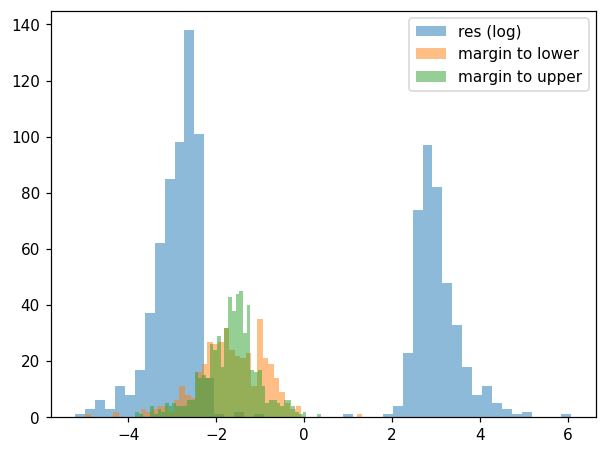

In [239]:
import matplotlib.pyplot as plt

plt.hist(results["res"], bins=50, alpha=0.5, label="res (log)")
plt.hist(results["margin_to_lower"], bins=50, alpha=0.5, label="margin to lower")
plt.hist(results["margin_to_upper"], bins=50, alpha=0.5, label="margin to upper")
plt.legend()
plt.show()


In [240]:
print("Total residuals:", len(results["res"]))
print("Residuals > 0 (neg_res path):", len(results["neg_res"]))
print("Residuals < 0 (pos_res path):", len(results["pos_res"]))
print("Condition (neg_res > y_lower):", sum(results["cond_lower"]))
print("Condition (pos_res < y_upper):", sum(results["cond_upper"]))


Total residuals: 1000
Residuals > 0 (neg_res path): 412
Residuals < 0 (pos_res path): 588
Condition (neg_res > y_lower): 1
Condition (pos_res < y_upper): 2


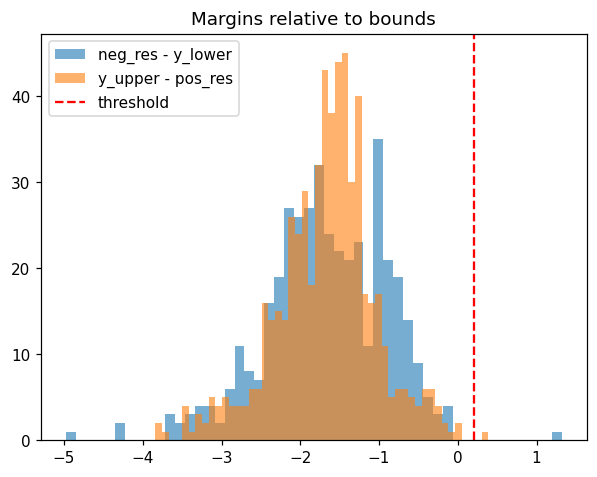

In [241]:
import matplotlib.pyplot as plt

plt.hist(results["margin_to_lower"], bins=50, alpha=0.6, label="neg_res - y_lower")
plt.hist(results["margin_to_upper"], bins=50, alpha=0.6, label="y_upper - pos_res")
plt.axvline(threshold, color="red", linestyle="--", label="threshold")
plt.legend()
plt.title("Margins relative to bounds")
plt.show()


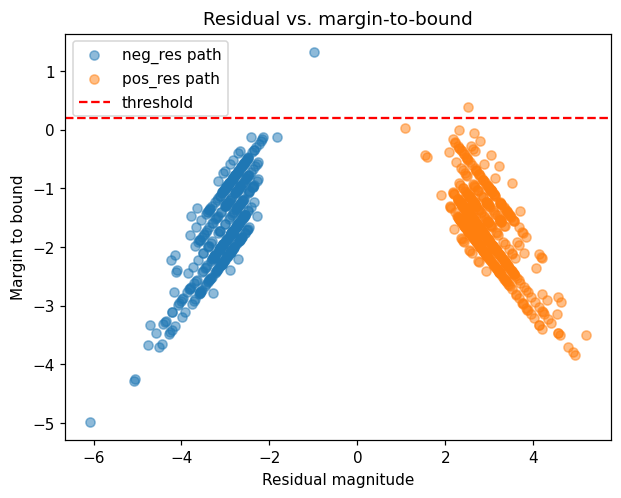

In [242]:
plt.scatter(results["neg_res"], results["margin_to_lower"], alpha=0.5, label="neg_res path")
plt.scatter(results["pos_res"], results["margin_to_upper"], alpha=0.5, label="pos_res path")
plt.axhline(threshold, color="red", linestyle="--", label="threshold")
plt.xlabel("Residual magnitude")
plt.ylabel("Margin to bound")
plt.legend()
plt.title("Residual vs. margin-to-bound")
plt.show()


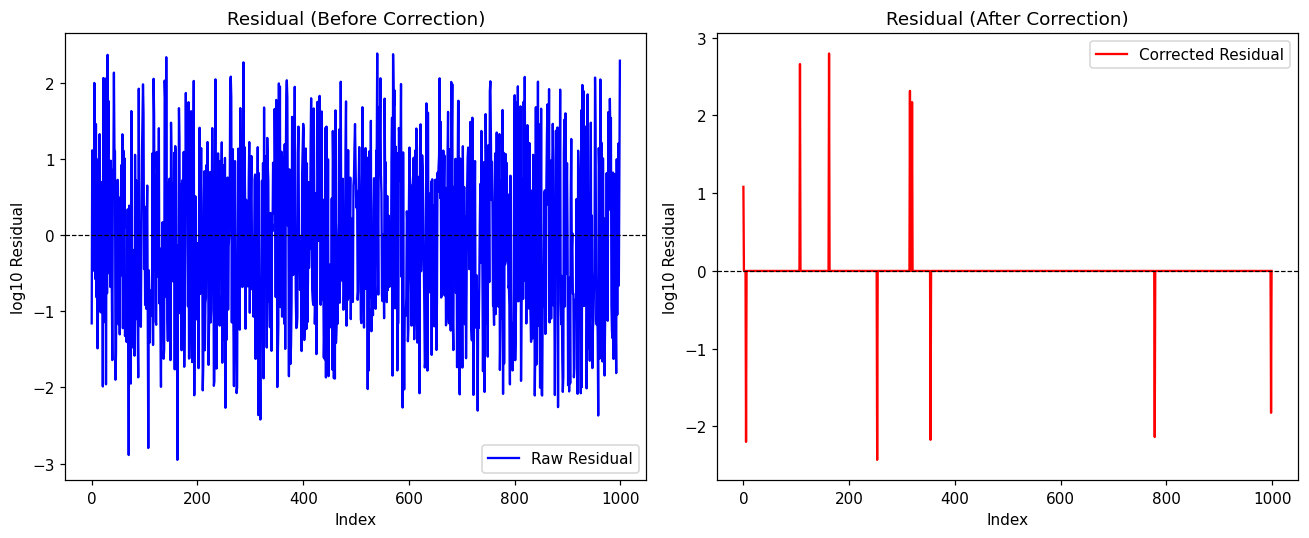

In [243]:
import matplotlib.pyplot as plt

# Assume log_residual (before correction) and corrected_residual (after correction) 
# are numpy arrays of the same length

plt.figure(figsize=(12, 5))

# --- Before correction ---
plt.subplot(1, 2, 1)
plt.plot(log_residual, label="Raw Residual", color="blue")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Residual (Before Correction)")
plt.xlabel("Index")
plt.ylabel("log10 Residual")
plt.legend()

# --- After correction ---
plt.subplot(1, 2, 2)
plt.plot(corrected_residual, label="Corrected Residual", color="red")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Residual (After Correction)")
plt.xlabel("Index")
plt.ylabel("log10 Residual")
plt.legend()

plt.tight_layout()
plt.show()


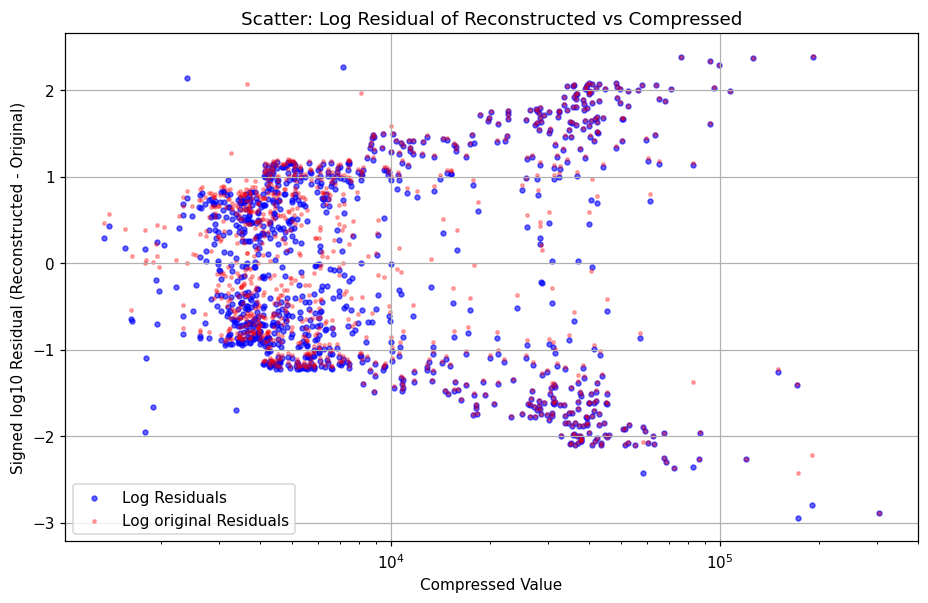

In [244]:
import matplotlib.pyplot as plt
import numpy as np
import torch


# Compute residual (reconstructed - original)
residual = recon - orig
residual_og = comp - orig

# Compute signed log10 residual
log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)
log_resigual_og = np.sign(residual_og) * np.log10(np.abs(residual_og) + 1e-12)
# Scatter plot: compressed vs log residual
plt.figure(figsize=(10, 6))
plt.scatter(comp, log_residual, s=10, alpha=0.6, c='blue', label='Log Residuals')
plt.scatter(comp, log_resigual_og, s=5, alpha=0.3, c='red', label='Log original Residuals')
plt.xlabel("Compressed Value")
plt.ylabel("Signed log10 Residual (Reconstructed - Original)")
plt.title("Scatter: Log Residual of Reconstructed vs Compressed")
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()
